# hIAPP WT Apo REST2 Simulation Analysis

The following produces the analysis for hIAPP WT Apo REST2 simulations, 20 replicas run on a 300 - 500 k temperature space. Here, we analyze the 300K replica. 

In [1]:
import mdtraj as md
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

sns.set_style("whitegrid")


In [3]:
# set the visualization style 
plt.rc('lines', linewidth=1)
plt.rcParams["font.size"]
plt.rcParams.update({"font.size":12, 'ytick.labelsize': '12', 'xtick.labelsize': '12', 'legend.fontsize': '10', 'axes.titlesize': '12'})
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [4]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = np.array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    print(variance)
    print(average)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = int(pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0])
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = int(pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0])
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


In [5]:
def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)


In [6]:
# put all our files 
outdir = './outdir_wt_hiapp_apo/'
!mkdir $outdir
pdb = "../structure_files/hiapp_wt_apo.gro"
rep0 = './hiapp_wt_apo_300k.xtc'
helixpdb = "../structure_files/helix_wt.pdb"

print("outdir:", outdir)
print("pdb:", pdb)
print("helix pdb:", helixpdb)
print("trjaectory:", rep0)


mkdir: ./outdir_wt_hiapp_apo/: File exists


outdir: ./outdir_wt_hiapp_apo/
pdb: ../structure_files/hiapp_wt_apo.gro
helix pdb: ../structure_files/helix_wt.pdb
trjaectory: ./hiapp_wt_apo_300k.xtc


In [7]:
trj = md.load(rep0, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames
sim_length = trj.time*80/(100000) # a frame saved every picosecond, time given in ns 
sim_length = sim_length[-1]

In [8]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 38
residue_offset = 1 
prot_res_renum = np.asarray(prot_res)
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)


** SYSTEM INFO **

Number of atoms: 537

Number of residues: 38

Number of protein residues: 37

Number of frames: 41501

Starting frame: 0

Last frame: 41501

sequence:  [LYS1, CYS2, ASN3, THR4, ALA5, THR6, CYS7, ALA8, THR9, GLN10, ARG11, LEU12, ALA13, ASN14, PHE15, LEU16, VAL17, HIS18, SER19, SER20, ASN21, ASN22, PHE23, GLY24, ALA25, ILE26, LEU27, SER28, SER29, THR30, ASN31, VAL32, GLY33, SER34, ASN35, THR36, TYR37, NH238]

residue names:  ['LYS', 'CYS', 'ASN', 'THR', 'ALA', 'THR', 'CYS', 'ALA', 'THR', 'GLN', 'ARG', 'LEU', 'ALA', 'ASN', 'PHE', 'LEU', 'VAL', 'HIS', 'SER', 'SER', 'ASN', 'ASN', 'PHE', 'GLY', 'ALA', 'ILE', 'LEU', 'SER', 'SER', 'THR', 'ASN', 'VAL', 'GLY', 'SER', 'ASN', 'THR', 'TYR', 'NH2']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]

Residue Number Range: range(0, 38)


In [9]:
# get the sequence of the protein for later plots 
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

n=2
m = len(sequence)
for i in range (0,m): 
    if (i % n !=0):
        sequence[i] = ""

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_86168/545675895.py:23: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


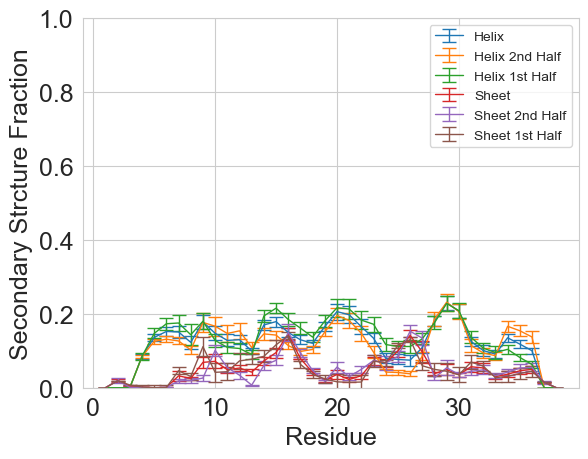

In [10]:
# compute the blocking error of the simulation to check for convergence 
trjH1 = md.load(rep0, top=pdb, stride=1)
H1 = top.select("resid 0 to 37")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames
half = int(np.floor(frames/2))

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
hres_renum = np.asarray(h_res)


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)
dsspH1_h2 = md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1 = md.compute_dssp(trjH1[0:half], simplified=True)

H1_H, H1_E = dssp_convert(dsspH1)
H1_H_h2, H1_E_h2 = dssp_convert(dsspH1_h2)
H1_H_h1, H1_E_h1 = dssp_convert(dsspH1_h1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(
    hres_renum, H1_H_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Helix 2nd Half')
plt.errorbar(
    hres_renum, H1_H_h1[:, 0], yerr=H1_H_h1[:, 1], capsize=5, label='Helix 1st Half')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.errorbar(
    hres_renum, H1_E_h1[:, 0], yerr=H1_E_h1[:, 1], capsize=5, label='Sheet 2nd Half')
plt.errorbar(
    hres_renum, H1_E_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Sheet 1st Half')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


In [11]:
# load the chespi bmrb output 
chespi_bmrb_34069 = np.loadtxt("./BMRB_34069.chespi.txt", dtype={'names': ( "res", "num", "Helix","x1", "x2", "Beta"),'formats': ('S1',"f4", "f4","f4", "f4","f4")})

In [16]:
# load in reweight data 
workdir = "/Users/f006j60/Robustelli_Group/Robustelli-Lab/IAPP/wt/analysis_02.23.23/cs/wt_iapp_reweight/"
weight_file=os.path.join(workdir, 'reweight_data/weights/single_data/CA/weights_final.dat')


In [23]:
weights=np.loadtxt(weight_file)
dsspH=np.copy(dsspH1)
dsspH = dsspH[1:]
dsspH[dsspH=='H']=1
dsspH[dsspH=='E']=0
dsspH[dsspH=='C']=0
dsspH[dsspH=='NA']=0
dsspH=dsspH.astype(int)
Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
# Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)

reweight_Hprop=[]
#reweight_Eprop=[]
for i in range(0,len(Hprop)):
    reweight_Hprop.append(np.dot(dsspH[:,i],weights))
    # reweight_Eprop.append(np.dot(dsspE[:,i],weights))

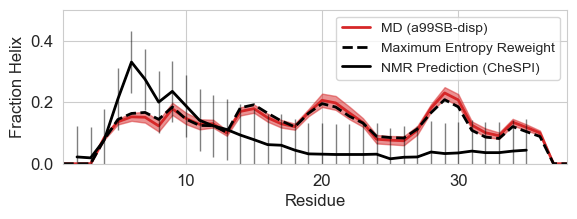

In [27]:
plt.figure(figsize=(6.5,2))
plt.plot(hres_renum, H1_H[:, 0], label='MD (a99SB-disp)', color = "tab:red", linewidth="2")
plt.fill_between(hres_renum, H1_H[:,0] + H1_H[:, 1], H1_H[:,0] - H1_H[:, 1], color="tab:red", alpha=0.5)

plt.plot(hres_renum, reweight_Hprop, label="Maximum Entropy Reweight", color = "black", linestyle="--", linewidth=2)
plt.plot(chespi_bmrb_34069["num"], chespi_bmrb_34069["Helix"], color="black", label="NMR Prediction (CheSPI)",linewidth=2)
# plt.fill_between(chespi_bmrb_34069["num"], chespi_bmrb_34069["Helix"] +0.10, chespi_bmrb_34069["Helix"] - 0.10, color="black", alpha=0.5)
plt.errorbar(chespi_bmrb_34069["num"], chespi_bmrb_34069["Helix"], yerr=0.10, alpha=0.5, color="k")
# plt.errorbar(chespi_bmrb_34069["num"], chespi_bmrb_34069["Beta"], yerr=0.10, label="CheSpi Sheet", color="red")


# plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
# plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.ylim(0,0.5)
plt.legend(loc="upper right", fontsize=10)
plt.xlabel('Residue')
plt.ylabel('Fraction Helix')
plt.xticks(np.arange(0,40,10))
# plt.tick_params(labelsize=10)
plt.xlim(1,38)
plt.savefig(outdir+'NMR_Validation_CheSPI_MD.pdf', dpi=300)
plt.savefig(outdir+'NMR_Validation_CheSPI_MD.svg', dpi=300)

In [13]:
def dssp_convert_more(dssp): 
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'G'] = 1
    dsspH[dsspH == 'I'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH[dsspH == ' '] = 0
    dsspH[dsspH == ''] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E
    

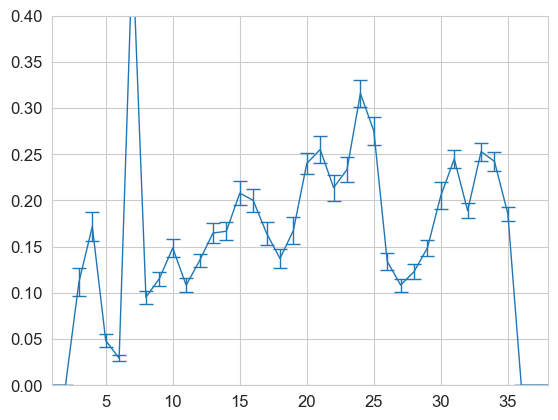

In [72]:
# dssp convert more 
dsspH1_more = md.compute_dssp(trjH1, simplified=False)
#bend_content = np.copy(dsspH1_more)
dsspH1_more = np.where(dsspH1_more == "S", 1, 0)
Sprop = np.sum(dsspH1_more, axis=0).astype(float)/len(dsspH1_more)
H1_S = np.zeros((len(dsspH1_more[0]), 2))
for i in range(0, len(dsspH1_more[0])):
        data = dsspH1_more[:, i].astype(float)
        if(np.mean(data) > 0):
            H1_S[i] = [np.mean(data), (block(data))**.5]

np.savetxt(outdir+'Sprop.err.dat', np.column_stack((hres_renum, H1_S[:, 0], H1_S[:, 1])))

plt.errorbar(hres_renum, H1_S[:,0], yerr=H1_S[:, 1], capsize=5, label='Bend')
plt.ylim(0, 0.40)
plt.xlim(1,38)
plt.show()

In [81]:
# Define the residue ranges for the two groups
group1_residues = range(0, 20)  # residues 1 to 20
group2_residues = range(20, 38)  # residues 21 to 38

# Compute secondary structure using DSSP
dssp = md.compute_dssp(trj)

# Define beta-sheet structure identifiers
beta_sheet_identifiers = ['E', 'B']

# Initialize arrays to store beta-sheet fractions for each frame
beta_sheet_fraction_group1 = np.zeros(trj.n_frames)
beta_sheet_fraction_group2 = np.zeros(trj.n_frames)

# Loop through each frame and compute the fraction of beta-sheet in both groups
for frame_idx in range(trj.n_frames):
    # Get DSSP annotations for group1 and group2 residues in the current frame
    group1_dssp = dssp[frame_idx][group1_residues]
    group2_dssp = dssp[frame_idx][group2_residues]
    
    # Compute the fraction of residues in group1 that are in beta-sheet conformation
    beta_sheet_count_group1 = sum(1 for ss in group1_dssp if ss in beta_sheet_identifiers)
    beta_sheet_fraction_group1[frame_idx] = beta_sheet_count_group1 / len(group1_residues)
    
    # Compute the fraction of residues in group2 that are in beta-sheet conformation
    beta_sheet_count_group2 = sum(1 for ss in group2_dssp if ss in beta_sheet_identifiers)
    beta_sheet_fraction_group2[frame_idx] = beta_sheet_count_group2 / len(group2_residues)

# Print the beta-sheet fraction for each frame
# for frame in range(trj.n_frames):
    # print(f'Frame {frame}: Beta-sheet fraction in Group 1 = {beta_sheet_fraction_group1[frame]:.2f}, '
    #       f'Beta-sheet fraction in Group 2 = {beta_sheet_fraction_group2[frame]:.2f}')

# Calculate the average beta-sheet fraction across all frames for both groups
average_beta_sheet_fraction_group1 = np.mean(beta_sheet_fraction_group1)
average_beta_sheet_fraction_group2 = np.mean(beta_sheet_fraction_group2)
# print(f'Average beta-sheet fraction in Group 1: {average_beta_sheet_fraction_group1:.2f}')
# print(f'Average beta-sheet fraction in Group 2: {average_beta_sheet_fraction_group2:.2f}')

# Calculate the correlation between the beta-sheet fractions of the two groups
correlation = np.corrcoef(beta_sheet_fraction_group1, beta_sheet_fraction_group2)[0, 1]
print(f'Correlation between beta-sheet fractions in Group 1 and Group 2: {correlation:.2f}')


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_72961/2606954009.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  beta_sheet_count_group1 = sum(1 for ss in group1_dssp if ss in beta_sheet_identifiers)
/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_72961/2606954009.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  beta_sheet_count_group2 = sum(1 for ss in group2_dssp if ss in beta_sheet_identifiers)


Correlation between beta-sheet fractions in Group 1 and Group 2: 0.76


R^2 value: 0.58


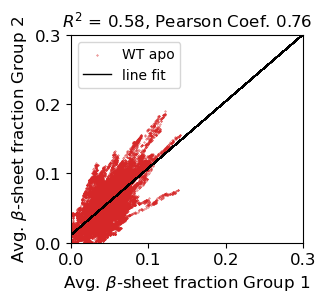

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
sns.reset_defaults()
# Reshape the data for linear regression
X = beta_sheet_fraction_group1.reshape(-1, 1)
y = beta_sheet_fraction_group2

# Create and fit the linear regression model
model = LinearRegression().fit(X, y)

# Predict the beta-sheet fraction in group2 based on the group1 data
y_pred = model.predict(X)

# Calculate the R^2 value
r2 = r2_score(y, y_pred)
print(f'R^2 value: {r2:.2f}')
N=100
plt.figure(figsize=(3.0,2.7))
plt.scatter(np.convolve(beta_sheet_fraction_group1, np.ones(N)/N), np.convolve(beta_sheet_fraction_group2, np.ones(N)/N),s=0.1,c="tab:red", label="WT apo")
# plt.plot([0,1],[0,1],c="k",linestyle="-")
plt.plot(beta_sheet_fraction_group1, y_pred, color='k', linewidth=1, label='line fit',marker="None")
plt.xlabel("Avg. $\\beta$-sheet fraction Group 1", fontsize=12)
plt.ylabel("Avg. $\\beta$-sheet fraction Group 2", fontsize=12)
plt.title(f"$R^2$ = {r2:.2f}, Pearson Coef. {correlation:.2f}", 
          fontsize=12)
plt.ylim(0,0.3)
plt.xlim(0, 0.3)
plt.xticks(np.linspace(0,0.3,4), fontsize=12)
plt.yticks(np.linspace(0,0.3,4),fontsize=12)
plt.legend()
plt.savefig(outdir+'EProp.1to20.20to38.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [83]:
# Define the residue ranges for the two groups
group1_residues = range(0, 24)  # residues 1 to 24
group2_residues = range(24, 38)  # residues 21 to 38

# Compute secondary structure using DSSP
dssp = md.compute_dssp(trj)

# Define beta-sheet structure identifiers
beta_sheet_identifiers = ['E', 'B']

# Initialize arrays to store beta-sheet fractions for each frame
beta_sheet_fraction_group1 = np.zeros(trj.n_frames)
beta_sheet_fraction_group2 = np.zeros(trj.n_frames)

# Loop through each frame and compute the fraction of beta-sheet in both groups
for frame_idx in range(trj.n_frames):
    # Get DSSP annotations for group1 and group2 residues in the current frame
    group1_dssp = dssp[frame_idx][group1_residues]
    group2_dssp = dssp[frame_idx][group2_residues]
    
    # Compute the fraction of residues in group1 that are in beta-sheet conformation
    beta_sheet_count_group1 = sum(1 for ss in group1_dssp if ss in beta_sheet_identifiers)
    beta_sheet_fraction_group1[frame_idx] = beta_sheet_count_group1 / len(group1_residues)
    
    # Compute the fraction of residues in group2 that are in beta-sheet conformation
    beta_sheet_count_group2 = sum(1 for ss in group2_dssp if ss in beta_sheet_identifiers)
    beta_sheet_fraction_group2[frame_idx] = beta_sheet_count_group2 / len(group2_residues)

# Print the beta-sheet fraction for each frame
# for frame in range(trj.n_frames):
    # print(f'Frame {frame}: Beta-sheet fraction in Group 1 = {beta_sheet_fraction_group1[frame]:.2f}, '
    #       f'Beta-sheet fraction in Group 2 = {beta_sheet_fraction_group2[frame]:.2f}')

# Calculate the average beta-sheet fraction across all frames for both groups
average_beta_sheet_fraction_group1 = np.mean(beta_sheet_fraction_group1)
average_beta_sheet_fraction_group2 = np.mean(beta_sheet_fraction_group2)
# print(f'Average beta-sheet fraction in Group 1: {average_beta_sheet_fraction_group1:.2f}')
# print(f'Average beta-sheet fraction in Group 2: {average_beta_sheet_fraction_group2:.2f}')

# Calculate the correlation between the beta-sheet fractions of the two groups
correlation = np.corrcoef(beta_sheet_fraction_group1, beta_sheet_fraction_group2)[0, 1]
print(f'Correlation between beta-sheet fractions in Group 1 and Group 2: {correlation:.2f}')

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_72961/2537965071.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  beta_sheet_count_group1 = sum(1 for ss in group1_dssp if ss in beta_sheet_identifiers)
/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_72961/2537965071.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  beta_sheet_count_group2 = sum(1 for ss in group2_dssp if ss in beta_sheet_identifiers)


Correlation between beta-sheet fractions in Group 1 and Group 2: 0.63


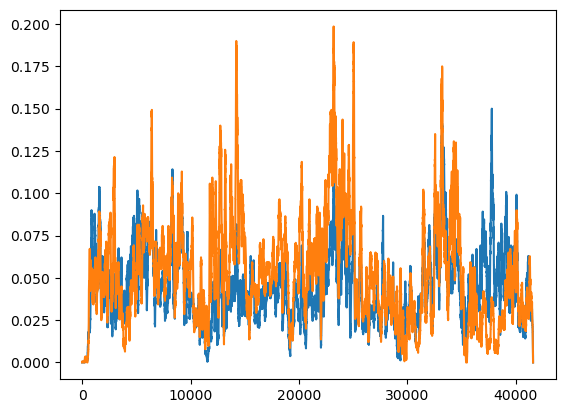

In [84]:
N=100
plt.plot(np.convolve(beta_sheet_fraction_group1, np.ones(N)/N))
plt.plot(np.convolve(beta_sheet_fraction_group2, np.ones(N)/N))
plt.show()

R^2 value: 0.40


<Figure size 640x480 with 0 Axes>

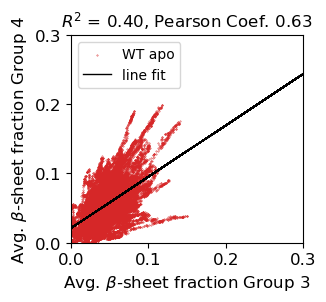

In [85]:
# Reshape the data for linear regression
plt.clf()
X = beta_sheet_fraction_group1.reshape(-1, 1)
y = beta_sheet_fraction_group2

# Create and fit the linear regression model
model = LinearRegression().fit(X, y)

# Predict the beta-sheet fraction in group2 based on the group1 data
y_pred = model.predict(X)

# Calculate the R^2 value
r2 = r2_score(y, y_pred)
print(f'R^2 value: {r2:.2f}')
N=100
plt.figure(figsize=(3.0,2.7))
plt.scatter(np.convolve(beta_sheet_fraction_group1, np.ones(N)/N), np.convolve(beta_sheet_fraction_group2, np.ones(N)/N),s=0.1,c="tab:red", label="WT apo")
# plt.plot([0,1],[0,1],c="k",linestyle="-")
plt.plot(beta_sheet_fraction_group1, y_pred, color='k', linewidth=1, label='line fit',marker="None")
plt.xlabel("Avg. $\\beta$-sheet fraction Group 3", fontsize=12)
plt.ylabel("Avg. $\\beta$-sheet fraction Group 4", fontsize=12)
plt.title(f"$R^2$ = {r2:.2f}, Pearson Coef. {correlation:.2f}", 
          fontsize=12)
plt.ylim(0,0.3)
plt.xlim(0, 0.3)
plt.xticks(np.linspace(0,0.3,4), fontsize=12)
plt.yticks(np.linspace(0,0.3,4),fontsize=12)
plt.legend()
plt.savefig(outdir+'EProp.1to24.24to38.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
dsspH = np.copy(dsspH1)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Average Helical Residues:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/56.0))

Average Helical Residues: 4.572 +_ 0.147
Average Fraction Helix: 0.082 +_ 0.003


In [15]:
# Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label = []
for i_phi in range(0, indices_phi.shape[0]):
    resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
    phi_label.append(resindex)
phi_label = np.array(phi_label)
psi_label = []

for i_psi in range(0, indices_psi.shape[0]):
    resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
    psi_label.append(resindex)
psi_label = np.array(psi_label)
phipsi = []
for i in range(0, len(psi_label)-2):
    current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
    phipsi.append(current_phipsi)
phipsi_array = np.array(phipsi)


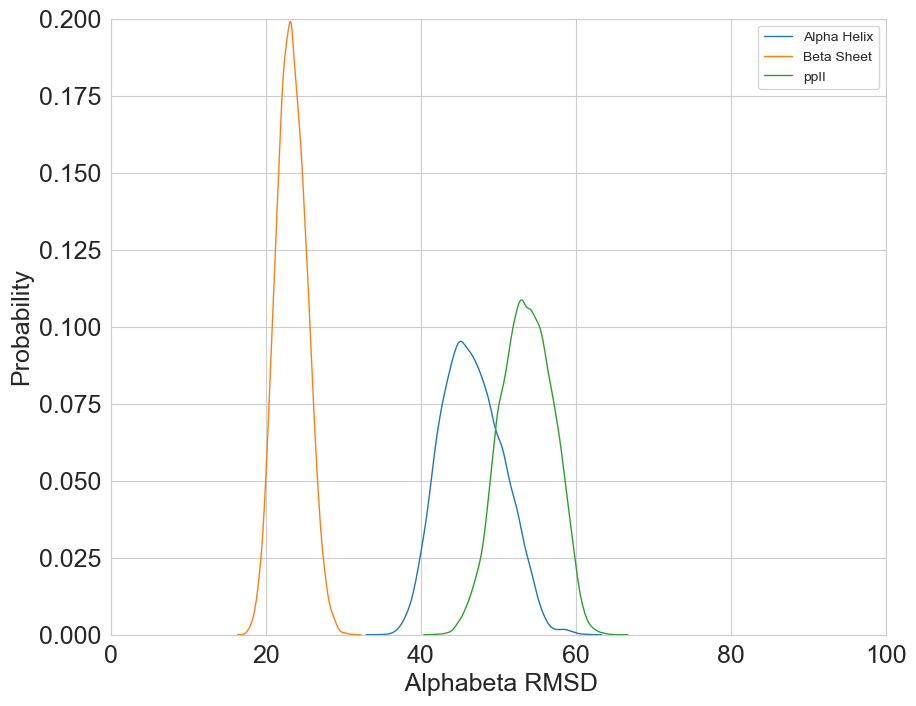

In [16]:
def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79) #-57 degrees, -47 degrees 
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

plt.figure(figsize=(10,8))

sns_kdeplot = sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns_kdeplot = sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns_kdeplot = sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
plt.xlim(0, 100)
plt.ylim(0, 0.20)

plt.ylabel('Probability', fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()
fig = sns_kdeplot.get_figure()
fig.savefig(outdir+'Alphabeta.histogram.png', dpi=200)


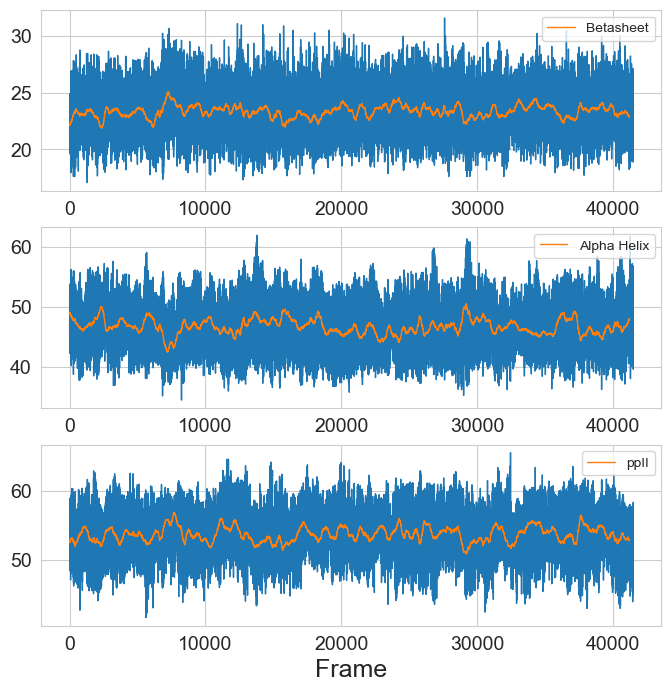

In [17]:
fig, ax = plt.subplots(3, figsize=((8, 8)))
N = 300
ax[0].plot(alphabeta_betasheet)
ax[0].plot(np.convolve(alphabeta_betasheet, np.ones(
    N)/N, mode='valid'), label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight, np.ones(
    N)/N, mode='valid'), label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(alphabeta_ppII)
ax[2].plot(np.convolve(alphabeta_ppII, np.ones(
    N)/N, mode='valid'), label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)

plt.xlabel('Frame', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png', dpi=200)


CA Radius of Gyration: 1.303 +_ 0.010
1st Half CA Radius of Gyration: 1.313 +_ 0.017
2nd Half CA Radius of Gyration: 1.294 +_ 0.009


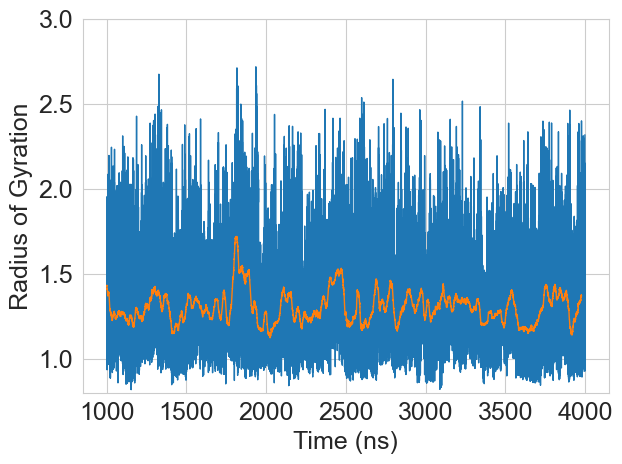

<Figure size 640x480 with 0 Axes>

In [18]:
mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
# calculate CA radius of gyration
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
# SE_rg=(block(rg_all))**.5
time = np.linspace(1000, 4000, trj.n_frames)
plt.clf()
plt.plot(time, rg_CA)
plt.plot(time[0:41202], np.convolve(rg_CA, np.ones(N)/N, mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.ylim(0.8, 3.0)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf" %
      np.average(rg_CA), "+_%6.3lf" % block(rg_CA)**.5)
print("1st Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[0:half]), "+_%6.3lf" % block(rg_CA[0:half])**.5)
print("2nd Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[half:-1]), "+_%6.3lf" % block(rg_CA[half:-1])**.5)
plt.show()
plt.savefig(outdir+'rg.pdf', dpi=200)
np.savetxt(outdir+'rg.dat', rg_CA)


Compute rh values according to the following script info: https://www.biorxiv.org/content/10.1101/679373v2

In [19]:
CA_atoms = trj.topology.select("name CA")
ca_trj = trj.atom_slice(CA_atoms, inplace=True)
rg = md.compute_rg(ca_trj)

Rg = rg * 10 

N = ca_trj.n_residues

def getRh(rg, N): 
    a1 = 0.216
    a2 = 4.06 
    a3 = 0.821

    return (rg) / ((a1*(rg-a2*N**(0.33)))/(N**(0.60)- N**(0.33))+a3)
Rh = getRh(Rg, N)/10

CA Hydrodynamic Radius: 1.597 +_ 0.004
1st Half CA Hydrodynamic Radius: 1.601 +_ 0.006
2nd Half CA Hydrodynamic Radius: 1.593 +_ 0.005


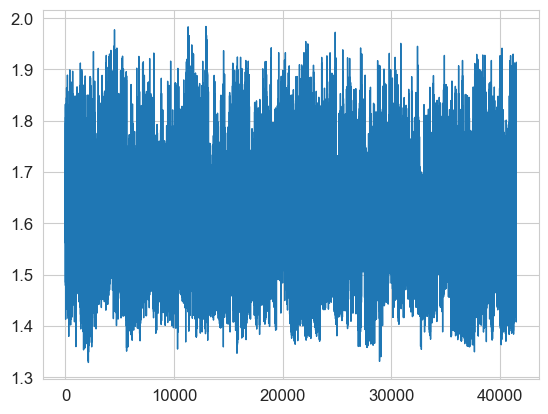

In [20]:
plt.plot(Rh)
print("CA Hydrodynamic Radius:%6.3lf" %
      np.average(Rh), "+_%6.3lf" % block(Rh)**.5)
print("1st Half CA Hydrodynamic Radius:%6.3lf" % np.average(
    Rh[0:half]), "+_%6.3lf" % block(Rh[0:half])**.5)
print("2nd Half CA Hydrodynamic Radius:%6.3lf" % np.average(
    Rh[half:-1]), "+_%6.3lf" % block(Rh[half:-1])**.5)

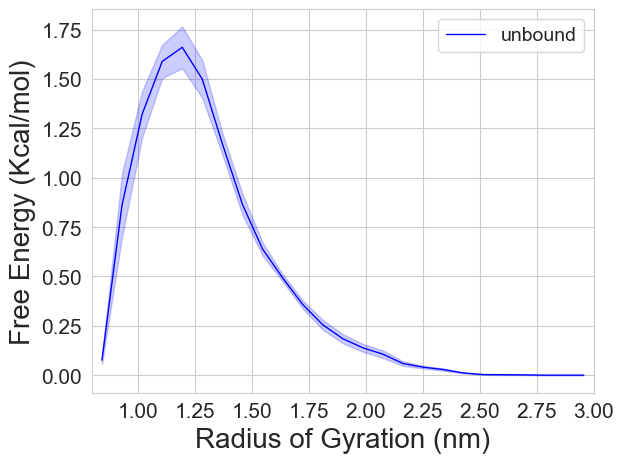

In [21]:
Rg_unbound, edges, u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_unbound, c='blue', label='unbound')
plt.fill_between(edges, Rg_unbound-u_err, Rg_unbound +
                 u_err, color='blue', alpha=0.2)

plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


[0.072 0.063 0.048 0.034 0.020 0.019 0.010 0.002 0.007 0.006 0.009 0.004
 0.007 0.003 0.004 0.001 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[2.182 2.228 2.041 1.770 1.390 1.103 0.874 0.732 0.555 0.438 0.350 0.264
 0.213 0.176 0.135 0.079 0.062 0.050 0.036 0.014 0.007 0.003 0.002 0.002
 0.000]


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_68100/545675895.py:65: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


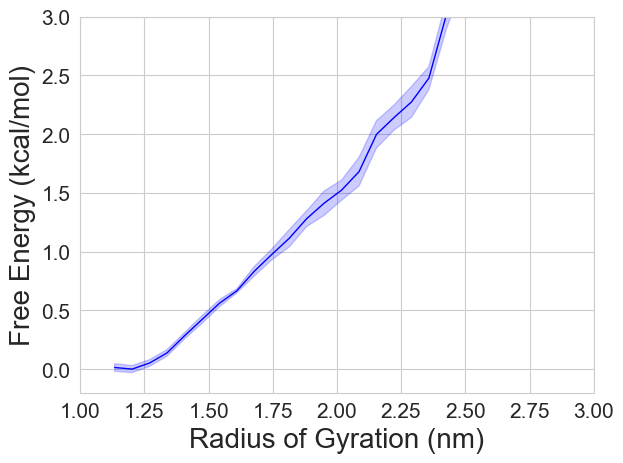

In [22]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA, 300, 1.1, 2.8, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 3)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir, dpi=200)
plt.show()


[0.179 0.212 0.073 0.072 0.065 0.073 0.021 0.005 0.005 0.012 0.010 0.006
 0.007 0.004 0.006 0.006 0.000 0.001 0.001 0.000 0.000 0.000 0.000 0.000
 0.000]
[2.149 2.140 2.044 1.780 1.481 1.185 0.883 0.731 0.553 0.451 0.408 0.306
 0.272 0.212 0.182 0.131 0.075 0.063 0.047 0.031 0.011 0.005 0.007 0.003
 0.002]
[0.179 0.058 0.052 0.039 0.018 0.023 0.015 0.008 0.006 0.006 0.010 0.006
 0.003 0.006 0.004 0.002 0.003 0.001 0.001 0.000 0.000 0.000 0.000 0.000
 0.000]
[2.243 2.344 2.091 1.810 1.373 1.114 0.951 0.767 0.616 0.502 0.345 0.257
 0.186 0.158 0.134 0.080 0.058 0.046 0.038 0.027 0.005 0.003 0.001 0.001
 0.000]


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_68100/545675895.py:65: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


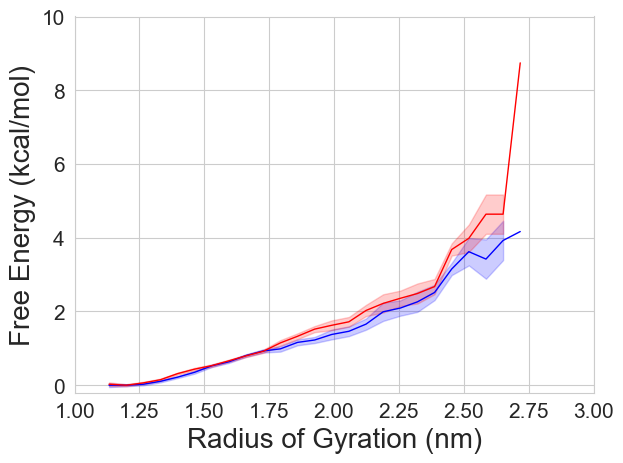

In [23]:
# [0:half],[half:-1]
dG1, bin_centers, ferr = free_energy_1D_blockerror(
    rg_CA[0:half], 300, 1.1, 2.75, 25, 5)
dG2, bin_centers, ferr = free_energy_1D_blockerror(
    rg_CA[half:-1], 300, 1.1, 2.75, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue')
sns.lineplot(x=bin_centers, y=dG2, color='red')

plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr, dG2+ferr, color='red', alpha=0.2)

plt.ylim(-0.2, 10)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.tight_layout()
plt.savefig('%s/Rg.dG.splithalfs.pdf' % outdir, dpi=200)
plt.show()

Here the original untruncated Sa plot is shown in order to display why the first microsecond of the simulation was discarded: 

Number of residues: 38

Sα: 1.832 +_ 0.165


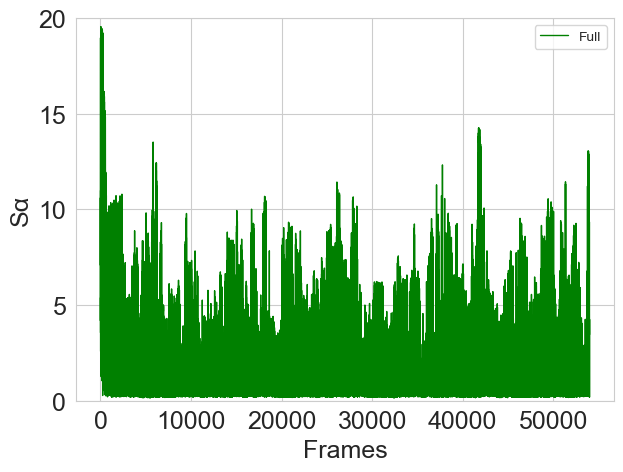

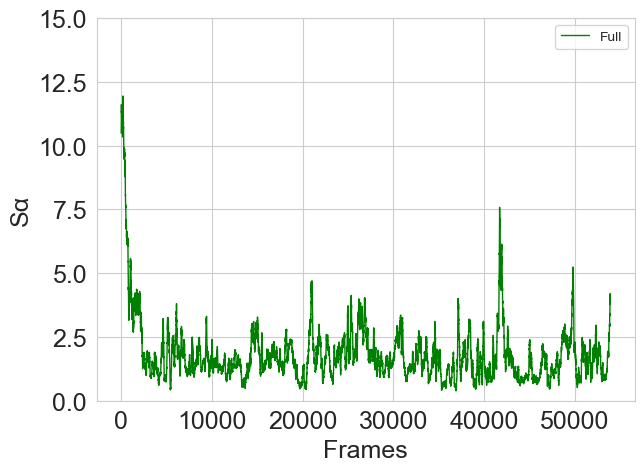

<Figure size 640x480 with 0 Axes>

In [24]:
trj_untrunc = md.load("./pbc_and_demux_trjs/pbc/pbc_1.xtc", top=pdb, stride=1)
helix = md.load_pdb(helixpdb)
helix
top_helix = helix.topology
backbone_helix = top_helix.select("name CA")
backbone = top.select("name CA")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 1
RMS_stop = 31
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = top_helix.select("residue %s to %s and name CA" % (i, i+6))
    rmsd = md.rmsd(trj_untrunc, helix, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj_untrunc.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)

print("Sα:%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 300
plt.plot(Sa_total, label='Full', c='g')
plt.legend()
plt.xlabel('Frames', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 20)
plt.savefig(outdir+'Sa.timecourse_untruncated.png', dpi=200)
np.savetxt(outdir+'Sa_total_untruncated.dat', Sa_total)
plt.show()
plt.clf()

del trj_untrunc

N = 100
plt.plot(np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
plt.legend()
plt.xlabel('Frames', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 15)
plt.savefig(outdir+'Sa.timecourse.smooth.untrunc.png', dpi=200)
plt.show()
plt.clf()

Number of residues: 38

Sα: 1.689 +_ 0.088


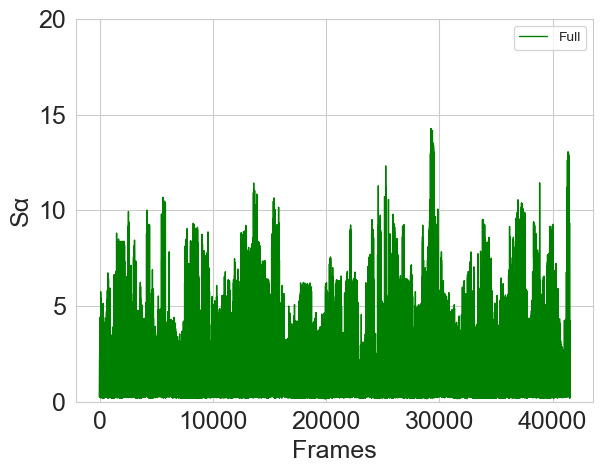

In [25]:
trj = md.load(rep0, top=pdb, stride=1)
helix = md.load_pdb(helixpdb)
top_helix = helix.topology
backbone_helix = top_helix.select("name CA")
backbone = top.select("name CA")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 1
RMS_stop = 31
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = top_helix.select("residue " + str(i) + " to " + str(i+6)+  " and name CA")
    rmsd = md.rmsd(trj, helix, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)
#Sa_R2 = np.sum(Sa[0:25], axis=0)
#Sa_R3 = np.sum(Sa[36:56], axis=0)

print("Sα:%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 300
plt.plot(Sa_total, label='Full', c='g')
#plt.plot(Sa_R2, label='R2', c='r')
#plt.plot(Sa_R3, label='R3', c='b')
plt.legend()
plt.xlabel('Frames', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 20)
plt.savefig(outdir+'Sa.timecourse.png', dpi=200)
np.savetxt(outdir+'Sa_total.dat', Sa_total)
#np.savetxt(outdir+'Sa_total.R2.dat', Sa_R2)
#np.savetxt(outdir+'Sa_total.R3.dat', Sa_R3)

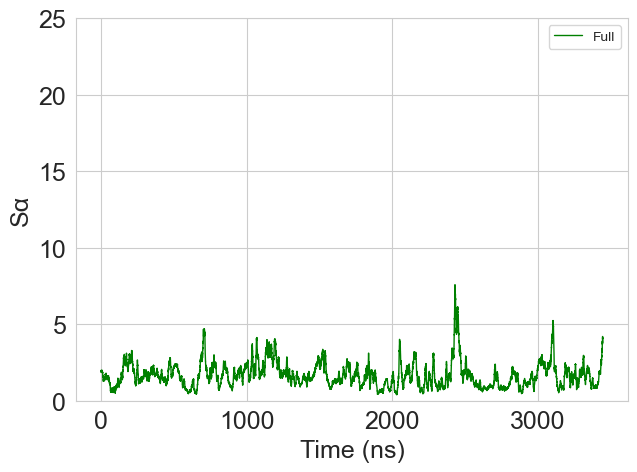

In [26]:
N = 100
time = np.linspace(0,sim_length, trj.n_frames)
plt.plot(time[:41402], np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.smooth.png', dpi=200)

In [27]:
# check to see the cooperative helix formation

first_half_sa = Sa[:15,:]
second_half_sa = Sa[15:, :]

avg_first_half_sa = np.average(first_half_sa,axis=1)
avg_second_half_sa = np.average(second_half_sa,axis=1)

sum_first_half_sa = np.sum(first_half_sa, axis=0)
sum_second_half_sa = np.sum(second_half_sa, axis=0)

cooperative_helix = np.where((sum_first_half_sa > 2) & (sum_second_half_sa > 2))[0] 
c_helix_frac = len(cooperative_helix)/trj.n_frames
print("Sα > 0.2:%6.3lf" % c_helix_frac,
      "+_%6.3lf" % (block(sum_first_half_sa)**2 + block(sum_second_half_sa)**2)**0.5)

Sα > 0.2: 0.040 +_ 0.005


In [28]:
# compute the mutual information
from sklearn.metrics import mutual_info_score

# get the mutual info score of a one-hot encoded array with cutoff. 
first_half_sa_oh = np.where(sum_first_half_sa > 1, 1, 0)
second_half_sa_oh = np.where(sum_second_half_sa > 1, 1, 0)

print(mutual_info_score(first_half_sa_oh, second_half_sa_oh))

0.012635299805063449


In [29]:
# conditional probability 
cooperative_helix = np.where((sum_first_half_sa > 1) & (sum_second_half_sa > 1))[0] 
c_helix_frac = len(cooperative_helix)/trj.n_frames
p_first_half = np.sum(first_half_sa_oh)/ trj.n_frames
p_second_half = np.sum(second_half_sa_oh)/ trj.n_frames

print(c_helix_frac/p_first_half)

0.35435937807518203


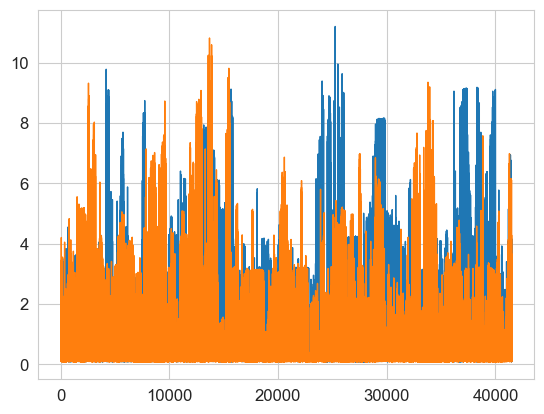

In [30]:
plt.plot(sum_first_half_sa)
plt.plot(sum_second_half_sa)
plt.show()

[0.002 0.000 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.572 0.141 0.091 0.069 0.039 0.031 0.022 0.013 0.014 0.005 0.001 0.000
 0.001 0.002 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_68100/545675895.py:65: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


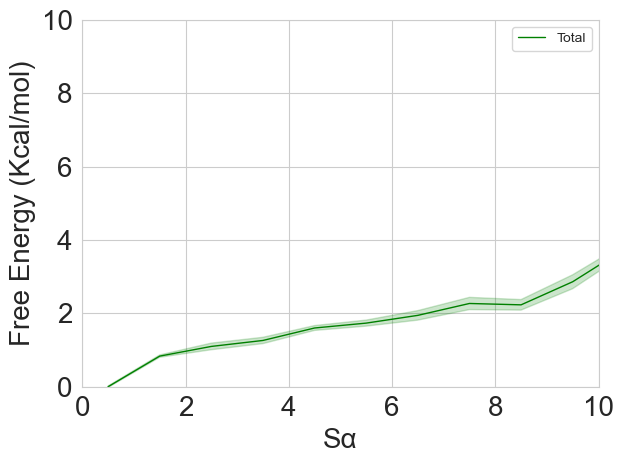

In [31]:
Sa_dg, edges, Sa_err = free_energy_1D_blockerror(Sa_total, 300, 0, 25, 25, 5)
plt.clf()
plt.plot(edges, Sa_dg, c='g', label='Total')
plt.fill_between(edges, Sa_dg-Sa_err, Sa_dg+Sa_err, color='g', alpha=0.2)


plt.legend()

plt.ylim(0, 10)
plt.xlim(0, 10)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
np.savetxt(outdir+'Sa_dg.dat', np.column_stack((edges, Sa_dg, Sa_err)))
plt.savefig('%s/Sa.dG.png' % outdir)

In [32]:

def calc_err(contact_binary, name):
    boundfrac_by_frame = []
    t2 = []
    err_by_frame = []
    err_upper = []
    err_lower = []
    time = np.linspace(0, sim_length, len(rg_CA))
    stride = 100
    for i in range(stride, len(contact_binary), stride):
        Data = np.asarray(contact_binary[0:i])
        bf, be = get_blockerror_pyblock_nanskip(Data)
        boundfrac_by_frame.append(bf)
        err_by_frame.append(be)
        err_upper.append(bf-be)
        err_lower.append(bf+be)
        t2.append(time[i])

    np.savetxt(outdir + name, np.column_stack((t2, boundfrac_by_frame, err_upper, err_lower)), '%.4f')

calc_err(rg_CA, 'rg.be.dat')
calc_err(Sa_total, 'Sa.be.dat')


/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_68100/2625601018.py:26: RuntimeWarning: divide by zero encountered in log
  dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_68100/2625601018.py:27: RuntimeWarning: divide by zero encountered in log
  dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_68100/2625601018.py:33: RuntimeWarning: invalid value encountered in double_scalars
  glob_dGs_err.append(dG_diff-dG_diff_upper)


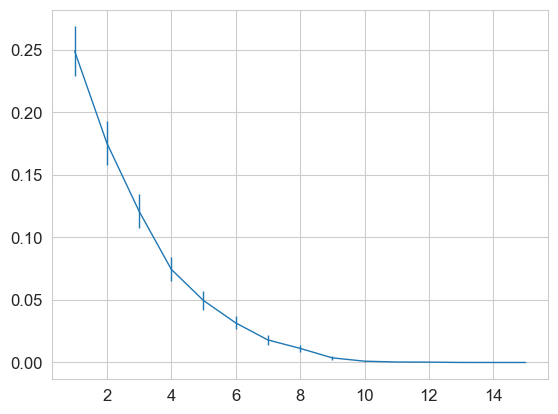

In [33]:
Sa_cut = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
glob_pops = []
glob_errs = []
glob_dGs = []
glob_dGs_err = []

rg_v_Sa = np.column_stack((rg_CA, Sa_total))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]

for i in Sa_cut:
    Sa_cutoff = i
    helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
    glob_index = np.intersect1d(collapsed, helical)
    globule_pop = len(glob_index)/len(rg_v_Sa)
    T = 300
    glob_binary = np.zeros(len(rg_v_Sa))
    glob_binary[glob_index] = 1
    glob_frac = len(glob_index)/len(glob_binary)
    glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
    #print("Bound Globule Fraction:",glob_boundfrac,"+_",glob_boundfrac_be)
    glob_upper = glob_boundfrac+glob_boundfrac_be
    non_glob = 1-glob_boundfrac
    non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
    #print("Non Globule Fraction:",1-glob_boundfrac,"+_",glob_boundfrac_be)
    dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
    dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                          glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
    #print("Free Energy Difference:",dG_diff,"+_",dG_diff-dG_diff_upper)
    glob_pops.append(globule_pop)
    glob_errs.append(glob_boundfrac_be)
    glob_dGs.append(dG_diff)
    glob_dGs_err.append(dG_diff-dG_diff_upper)

plt.errorbar(Sa_cut, glob_pops, yerr=glob_errs)
plt.show()
np.savetxt(outdir+'Pop.vs.Sacut.dat',
           np.column_stack((Sa_cut, glob_pops, glob_errs)))


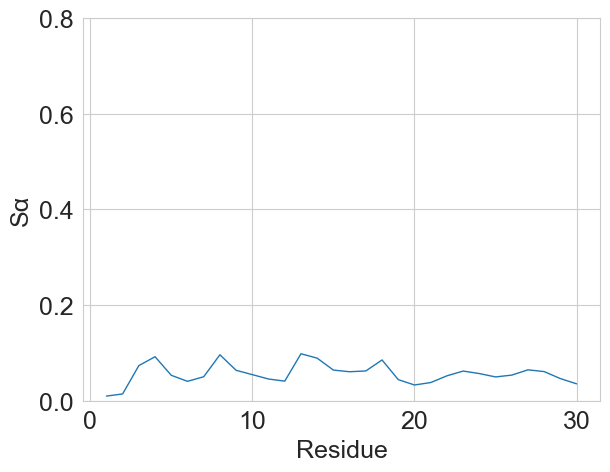

In [34]:
plt.plot(prot_res_renum[0:30], Sa_ave)
plt.xlabel('Residue', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 0.8)
plt.savefig('%s/Sa.ave.png' % outdir)


In [35]:
contact_maps = []
contact_distances = []
for i in residue_number:
    contact_map = []
    contact_distance = []
    for j in residue_number:
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.8, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [36]:
sequence_ol = []
for i in range(0, len(sequence)):
    sequence_ol.append(str(trj.topology.residue(i).code))
sequence_ol = sequence_ol[:-1]
sequence_ol.append("    NH2") # append NH2

<Figure size 640x480 with 0 Axes>

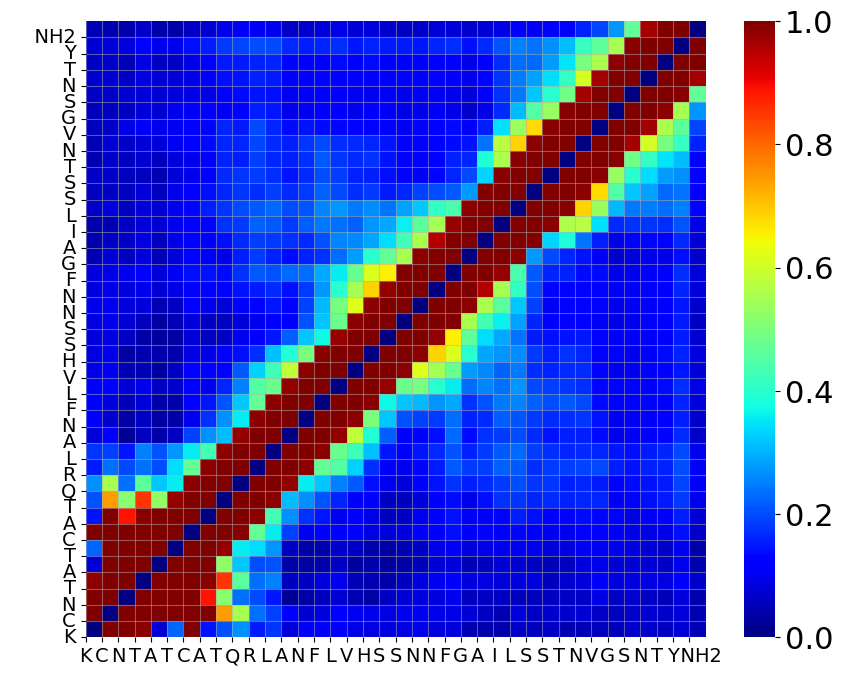

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
contact_map = final_map

plt.clf()
# Make distance map
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(np.arange(0, len(residue_number_offsetres)), sequence_ol, rotation=0, size=14)
plt.yticks(np.arange(0, len(residue_number_offsetres)), sequence_ol, rotation=0, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()
plt.show()

np.savetxt(outdir+'contactmap.dat', final_map)
plt.savefig(outdir+'contact_map.png')
plt.savefig(outdir+'contact_map.pdf')
plt.show()

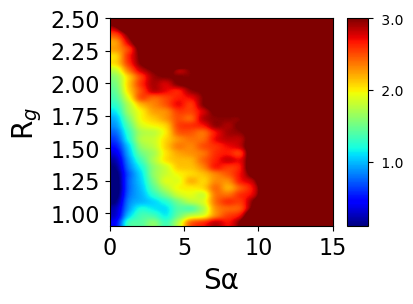

In [38]:
plt.figure(figsize=(3.6,2.7))
a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]

imaxes = plt.gca()
plt.xlim(0, 15)
plt.ylim(0.9,2.5)
plt.ylabel("R$_g$", size=20, labelpad=5)
plt.xlabel("Sα", size=20, labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                aspect=10)
#plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.show()

np.savetxt(outdir+'Apo.Rg_v_Sa.dG.dat', a)
plt.savefig(outdir+'Apo.Rg_v_Sa.dG.pdf', bbox_inches="tight",dpi=400)


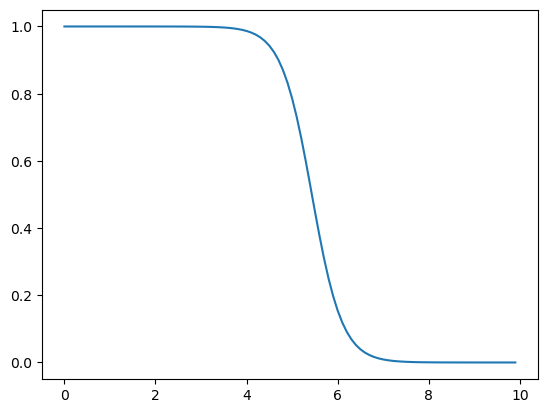

In [39]:
plt.clf()
dists = np.arange(0, 10, 0.1)
def sigmoid(x, a, b):
      
    z = np.exp(-(a*x+b))
    sig = 1- 1 / (1 + z)

    return sig
# switch = (1.0-((dists-max)/min)**8)/(1-((dists-max)/min)**12)

plt.plot(dists,sigmoid(dists, 3, -16.3))
plt.show()


[2.181 0.584 0.167 ... 2.237 2.042 1.999]


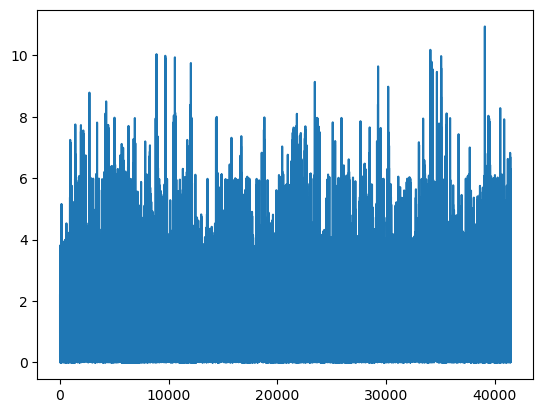

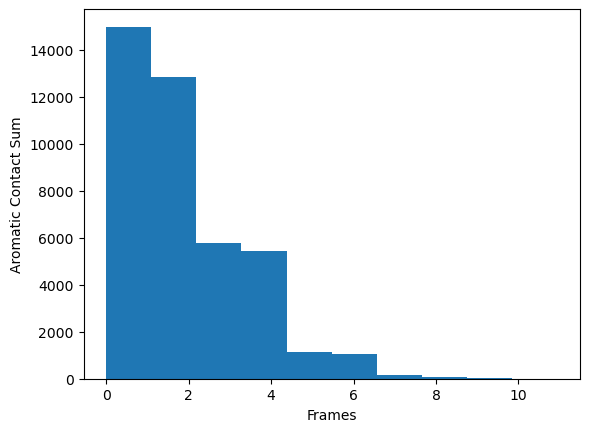

<Figure size 640x480 with 0 Axes>

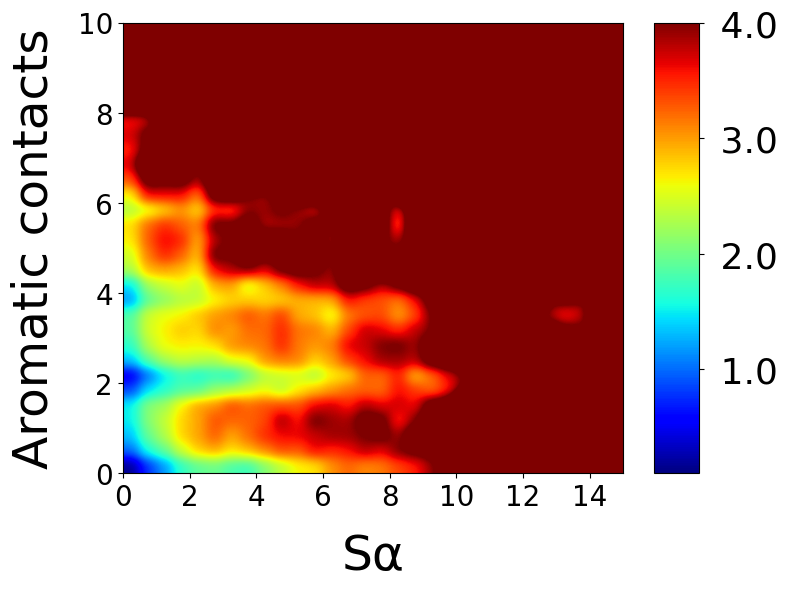

In [40]:
# Protein-protein
# Cut-off 4A, 7A
# 'closest-heavy'
prot_aromatic_res_index = [14, 17, 22, 36]
aromatic_contact_pairs = []
for i in range(len(prot_aromatic_res_index)):
    aromatic_contact_pair = []
    for j in range(len(prot_aromatic_res_index)): 
        pair = [prot_aromatic_res_index[i], prot_aromatic_res_index[j]]
        dist = md.compute_contacts(trj, [pair], scheme='closest-heavy')
        dists = np.asarray(dist[0]).astype(float)
        switch_aro = sigmoid(dists*10, 3, -16.3)
        aromatic_contact_pair.append(switch_aro)
    aromatic_contact_pairs.append(aromatic_contact_pair) 
aromatic_contact_pairs = np.asarray(aromatic_contact_pairs).astype(float)
aromatic_contact_sum = aromatic_contact_pairs.sum(axis = 0).sum(axis = 0)- len(prot_aromatic_res_index)
aromatic_contact_sum = aromatic_contact_sum[:,0]
print(aromatic_contact_sum)
plt.plot(aromatic_contact_sum)
plt.show()
plt.clf()

plt.hist(aromatic_contact_sum)
plt.xlabel("Frames")
plt.ylabel("Aromatic Contact Sum")
plt.show()
plt.clf()


dG, xedges, yedges = free_energy(aromatic_contact_sum, Sa_total, 300, 0, 10, 0, 15)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlabel("Sα", size=35, labelpad=15)
plt.ylabel("Aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='20')
plt.yticks(size='20')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=4.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.pdf')

In [41]:
Sa_vs_aromatic = np.column_stack((Sa_total, aromatic_contact_sum))
Sa_min = [0,0,2]
Sa_max = [2,2,4]
aromatic_min = [5, 15,5]
aromatic_max = [15, 25,15]
basin = []
for i in range(len(Sa_min)):
    Sa_basin = np.where((Sa_vs_aromatic[:, 0] > Sa_min[i]) & (Sa_vs_aromatic[:, 0] < Sa_max[i]))[0]
    aromatic_basin = np.where((Sa_vs_aromatic[:, 1] > aromatic_min[i]) & (Sa_vs_aromatic[:, 1] < aromatic_max[i]))[0]
    basin_index = np.intersect1d(Sa_basin, aromatic_basin)
    newtraj = trj[basin_index]
    md.Trajectory.save_xtc(newtraj, outdir + 'Sa.aromatic.%s.xtc' % i)
    print(newtraj)
    basin.append(basin_index)
print(basin)

<mdtraj.Trajectory with 959 frames, 537 atoms, 38 residues, and unitcells>
<mdtraj.Trajectory with 0 frames, 537 atoms, 38 residues, and unitcells>
<mdtraj.Trajectory with 378 frames, 537 atoms, 38 residues, and unitcells>
[array([  918,   925,   932,   936,   938,   950,   954,  1004,  1026,
        1082,  1083,  1207,  1211,  1381,  1394,  1396,  1397,  1403,
        1405,  1411,  1412,  1413,  1418,  1425,  1428,  1434,  1435,
        1438,  1439,  1482,  1491,  1504,  1636,  1639,  1768,  1774,
        1805,  1848,  1883,  1884,  1996,  2001,  2013,  2028,  2030,
        2053,  2064,  2170,  2226,  2230,  2248,  2251,  2253,  2257,
        2264,  2265,  2267,  2268,  2277,  2279,  2328,  2380,  2851,
        3330,  3361,  3364,  3365,  3411,  3460,  3577,  3578,  3851,
        3878,  3894,  4065,  4432,  4471,  4474,  4478,  4498,  4622,
        4723,  4736,  4978,  5241,  5320,  5379,  5387,  5427,  5439,
        5441,  5487,  5778,  5866,  5880,  5885,  5899,  5901,  5913,
      

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/mdtraj/utils/unitcell.py:78: UserWarning: All your angles were less than 2*pi. Did you accidentally give me radians?
  warnings.warn('All your angles were less than 2*pi. Did you accidentally give me radians?')


In [42]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [43]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}
top = trj.top
for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [44]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
        plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
        plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
        plt.xlabel('$\chi_1$', size=18)
        plt.ylabel('counts', size=18)
        plt.tick_params(labelsize=18)
        plt.show()
        plt.clf()   
    
    if res in dihedral_dict['chi2']:
     print("here")
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

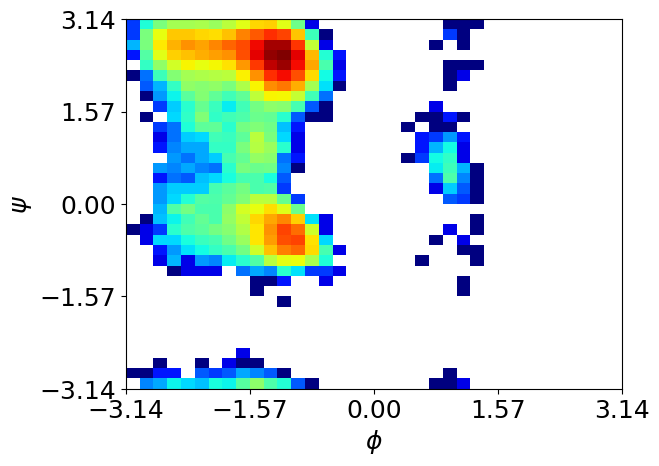

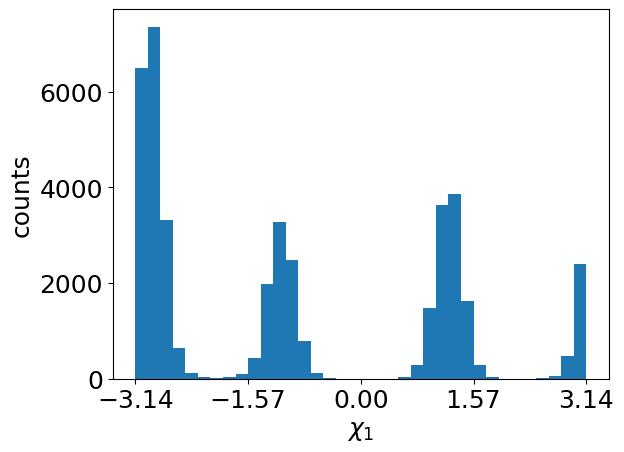

In [45]:
from matplotlib import colors
plot_phipsi(7)
plt.clf()
plot_chi(7)

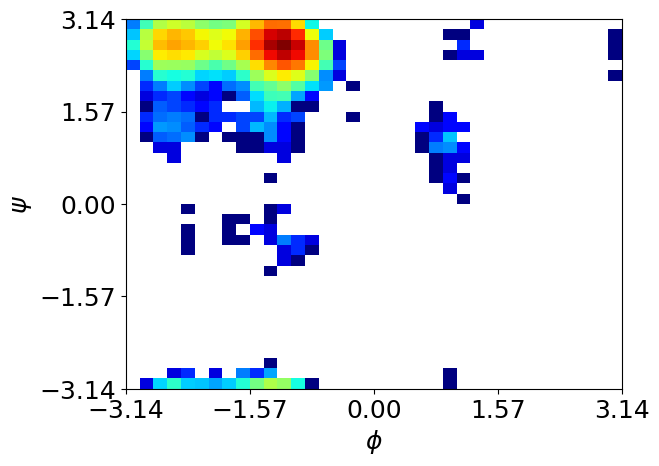

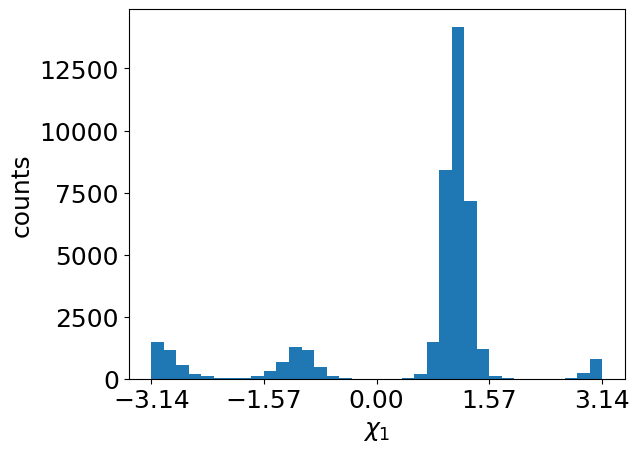

In [46]:
plot_phipsi(2)
plt.clf()
plot_chi(2)

In [47]:
def get_xyz_from_indx(indx): 
    return trj.xyz [:,indx]

(41501, 3)


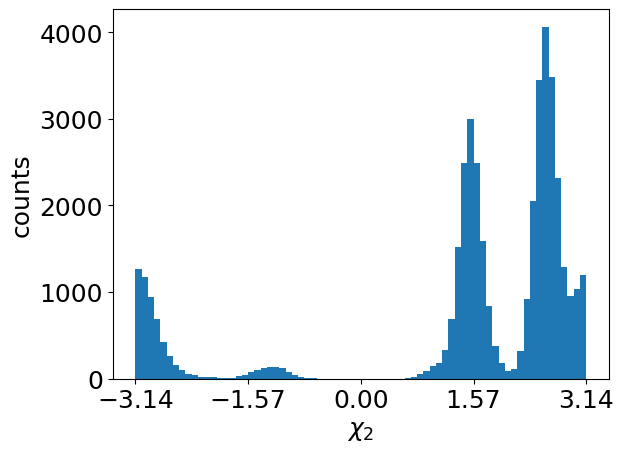

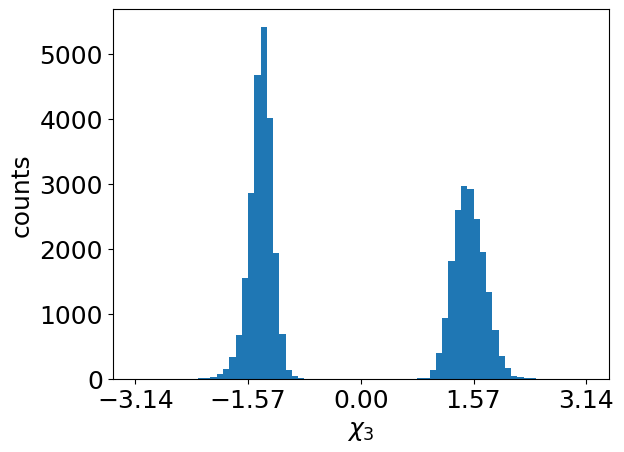

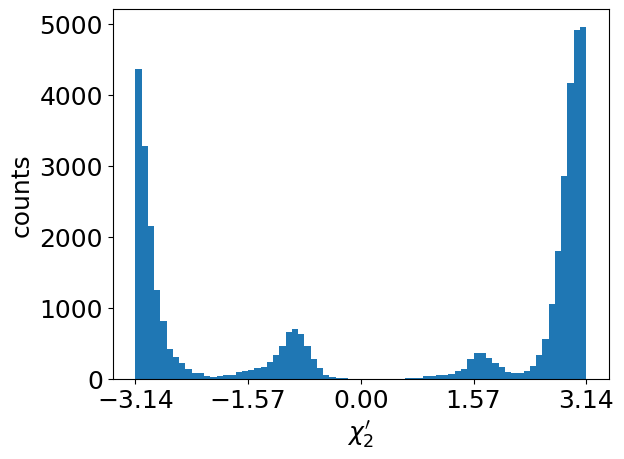

In [48]:
# x2 x3 x2p 
indxs = [[26,28,31,93], [28,31,93,90], [31,93,90,88]]

labels = ['$\chi_2$', '$\chi_3$', '$\chi_2\'$']

x2 = md.compute_dihedrals(trj,indxs)
print(x2.shape)
for i in range(3):
    angle_ls = x2[:,i] 
    lab = labels[i]
    plt.hist(angle_ls,bins=72,range=[-3.14,3.14])      
    plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
    plt.xlabel(lab, size=18)
    plt.ylabel('counts', size=18)
    plt.tick_params(labelsize=18)
    #plt.plot(angle_ls)
    plt.show()
#plt.clf() 

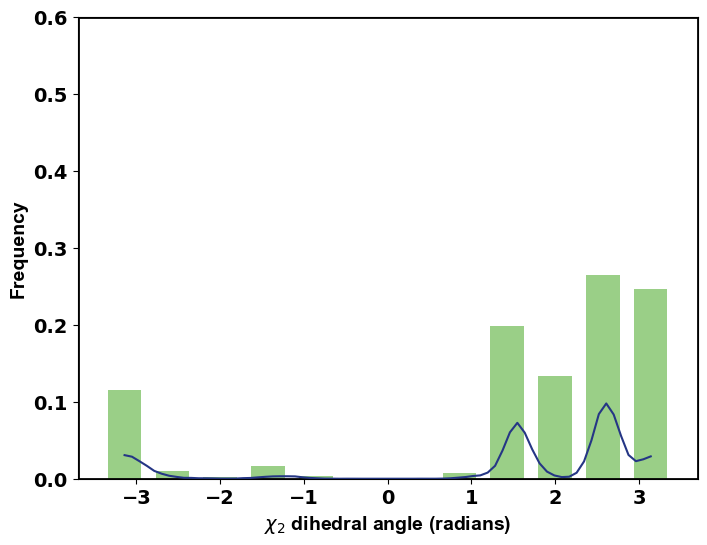

In [49]:
import pandas as pd
hfont = {"fontname":"arial"}
col = ['chi_2', 'chi_3', 'chi_2p']
df_ang = pd.DataFrame(data=x2, columns=col)
fig = plt.figure(figsize=(8,6), frameon=False, edgecolor="k")
#df_ang["chi_2"].hist(bins=6)
x = np.linspace(start=-3.14, stop=3.14, num=12)
plt.bar(x,df_ang['chi_2'].value_counts(bins=12, sort=False).to_numpy()/trj.n_frames, width=0.4, alpha=0.8, color="#81C469")
x = np.linspace(start=-3.14, stop=3.14, num=72)
y = df_ang['chi_2'].value_counts(bins=72, sort=False).to_numpy()/trj.n_frames
plt.plot(x,y, "-", color="#253685")
plt.xlabel("$\chi_{2}$ dihedral angle (radians)", fontweight="bold", fontsize=14, **hfont)
plt.ylabel("Frequency", fontweight="bold", fontsize=14, **hfont)
plt.xticks(fontweight="bold", fontsize=14)
plt.yticks(fontweight="bold", fontsize=14)
plt.grid(visible=False)
#plt.axhline(linewidth=2, color="k")
plt.axhspan(0, 0,linewidth=2, color="k")
plt.axhspan(0.6, 0.6,linewidth=2, color="k")
#plt.axvline(linewidth=2, color="k")
plt.axvspan(-3.7,-3.7, linewidth=2, color="k")
plt.axvspan(3.7,3.7, linewidth=2, color="k")
plt.xlim((-3.7,3.7))
plt.ylim((0, 0.6))
plt.show()


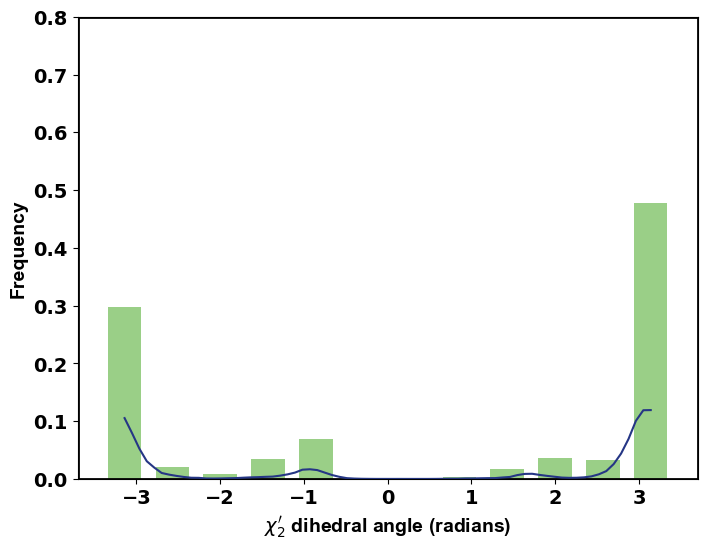

In [50]:
fig = plt.figure(figsize=(8,6), frameon=False, edgecolor="k")
#df_ang["chi_2"].hist(bins=6)
x = np.linspace(start=-3.14, stop=3.14, num=12)
plt.bar(x,df_ang['chi_2p'].value_counts(bins=12, sort=False).to_numpy()/trj.n_frames, width=0.4, alpha=0.8, color="#81C469")
x = np.linspace(start=-3.14, stop=3.14, num=72)
y = df_ang['chi_2p'].value_counts(bins=72, sort=False).to_numpy()/trj.n_frames
plt.plot(x,y, "-", color="#253685")
plt.xlabel("$\chi_{2}\'$ dihedral angle (radians)", fontweight="bold", fontsize=14, **hfont)
plt.ylabel("Frequency", fontweight="bold", fontsize=14, **hfont)
plt.xticks(fontweight="bold", fontsize=14)
plt.yticks(fontweight="bold", fontsize=14)
plt.grid(visible=False)
#plt.axhline(linewidth=2, color="k")
plt.axhspan(0, 0,linewidth=2, color="k")
plt.axhspan(0.8, 0.8,linewidth=2, color="k")
#plt.axvline(linewidth=2, color="k")
plt.axvspan(-3.7,-3.7, linewidth=2, color="k")
plt.axvspan(3.7,3.7, linewidth=2, color="k")
plt.xlim((-3.7,3.7))
plt.ylim((0, 0.8))
plt.show()

In [51]:
sum_chi2_12 = ((df_ang['chi_2p'].value_counts(bins=12, sort=False).to_numpy()/trj.n_frames) + (df_ang['chi_2'].value_counts(bins=12, sort=False).to_numpy()/trj.n_frames))/2
sum_chi2_72 = ((df_ang['chi_2p'].value_counts(bins=72, sort=False).to_numpy()/trj.n_frames) + (df_ang['chi_2'].value_counts(bins=72, sort=False).to_numpy()/trj.n_frames))/2

<Figure size 640x480 with 0 Axes>

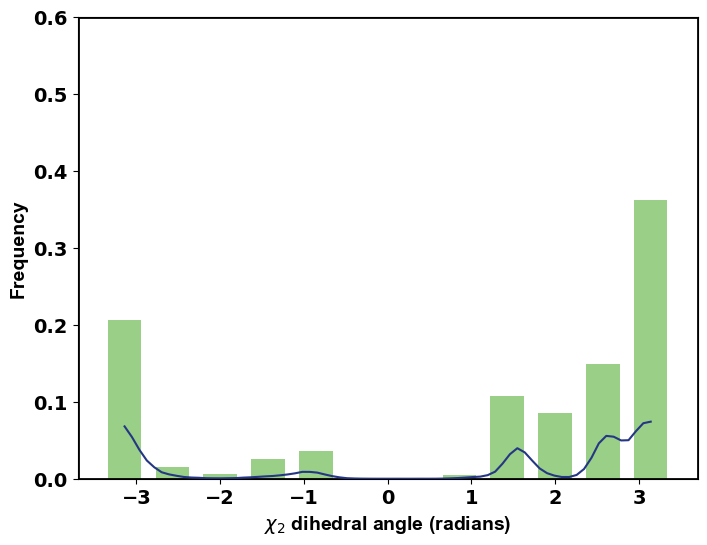

In [52]:
import pandas as pd
hfont = {"fontname":"arial"}
col = ['chi_2', 'chi_3', 'chi_2p']
df_ang = pd.DataFrame(data=x2, columns=col)
plt.clf()
fig = plt.figure(figsize=(8,6), frameon=False, edgecolor="k")
#df_ang["chi_2"].hist(bins=6)
x = np.linspace(start=-3.14, stop=3.14, num=12)

plt.bar(x,sum_chi2_12, width=0.4, alpha=0.8, color="#81C469")

x = np.linspace(start=-3.14, stop=3.14, num=72)
y = sum_chi2_72
plt.plot(x,y, "-", color="#253685")
plt.xlabel("$\chi_{2}$ dihedral angle (radians)", fontweight="bold", fontsize=14, **hfont)
plt.ylabel("Frequency", fontweight="bold", fontsize=14, **hfont)
plt.xticks(fontweight="bold", fontsize=14)
plt.yticks(fontweight="bold", fontsize=14)
plt.grid(visible=False)
#plt.axhline(linewidth=2, color="k")
plt.axhspan(0, 0,linewidth=2, color="k")
plt.axhspan(0.6, 0.6,linewidth=2, color="k")
#plt.axvline(linewidth=2, color="k")
plt.axvspan(-3.7,-3.7, linewidth=2, color="k")
plt.axvspan(3.7,3.7, linewidth=2, color="k")
plt.xlim((-3.7,3.7))
plt.ylim((0, 0.6))
plt.show()


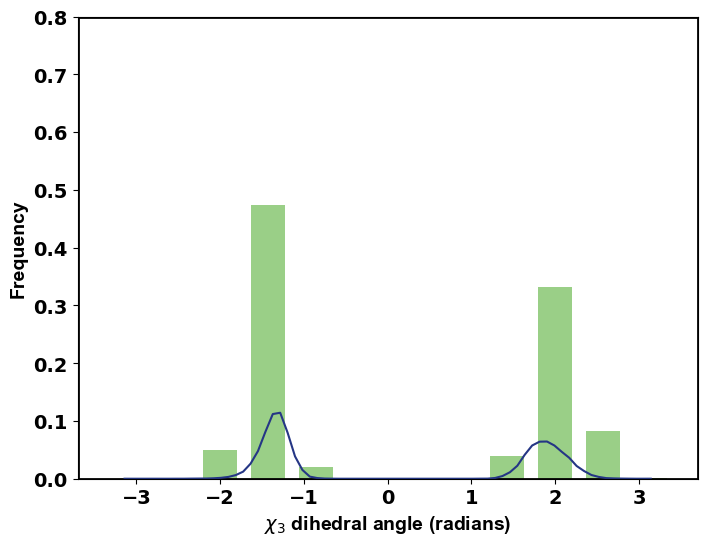

In [53]:
fig = plt.figure(figsize=(8,6), frameon=False, edgecolor="k")
#df_ang["chi_2"].hist(bins=6)
x = np.linspace(start=-3.14, stop=3.14, num=12)
plt.bar(x,df_ang['chi_3'].value_counts(bins=12, sort=False).to_numpy()/trj.n_frames, width=0.4, alpha=0.8, color="#81C469")
x = np.linspace(start=-3.14, stop=3.14, num=72)
y = df_ang['chi_3'].value_counts(bins=72, sort=False).to_numpy()/trj.n_frames
plt.plot(x,y, "-", color="#253685")
plt.xlabel("$\chi_{3}$ dihedral angle (radians)", fontweight="bold", fontsize=14, **hfont)
plt.ylabel("Frequency", fontweight="bold", fontsize=14, **hfont)
plt.xticks(fontweight="bold", fontsize=14)
plt.yticks(fontweight="bold", fontsize=14)
plt.grid(visible=False)
#plt.axhline(linewidth=2, color="k")
plt.axhspan(0, 0,linewidth=2, color="k")
plt.axhspan(0.8, 0.8,linewidth=2, color="k")
#plt.axvline(linewidth=2, color="k")
plt.axvspan(-3.7,-3.7, linewidth=2, color="k")
plt.axvspan(3.7,3.7, linewidth=2, color="k")
plt.xlim((-3.7,3.7))
plt.ylim((0, 0.8))
plt.show()

Check the distribution of the disulfide bond in pdb id: 5MGQ 

In [54]:
trj_5mgq = md.load("./5mgq.pdb")

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


(20, 3)


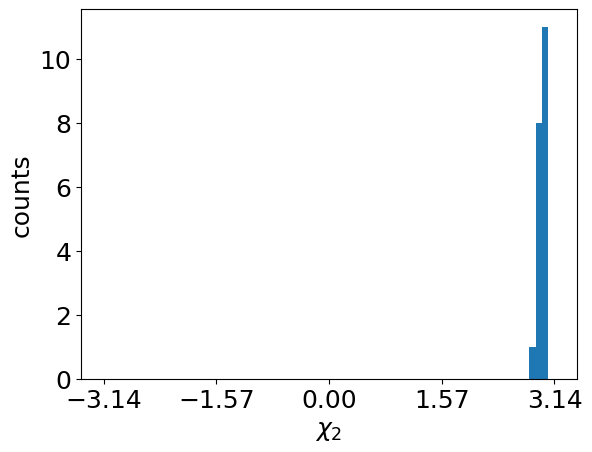

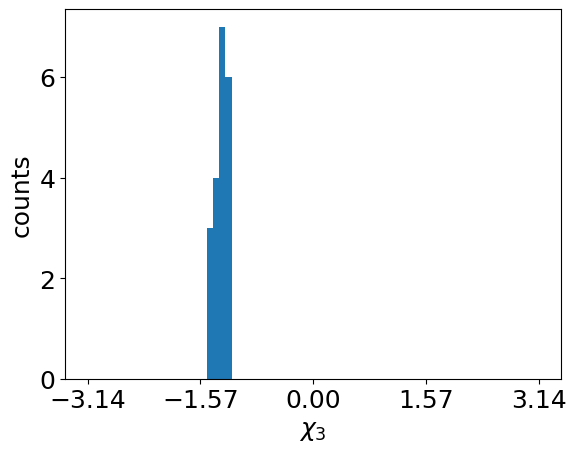

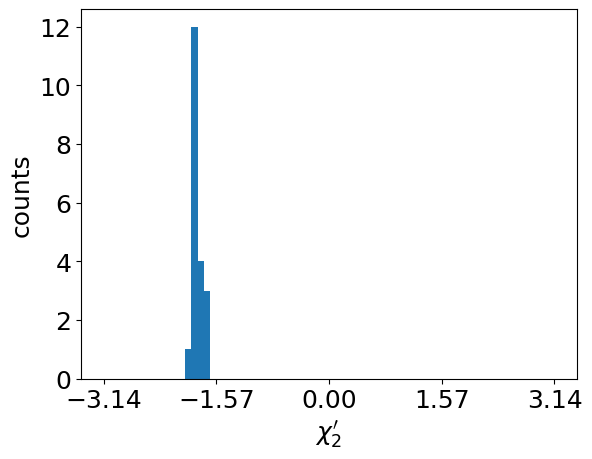

In [55]:
indxs = [[25,28,29,91], [28,29,91,90], [29,91,90,87]]

labels = ['$\chi_2$', '$\chi_3$', '$\chi_2\'$']

x2 = md.compute_dihedrals(trj_5mgq,indxs)
print(x2.shape)
for i in range(3):
    angle_ls = x2[:,i] 
    lab = labels[i]
    plt.hist(angle_ls,bins=72,range=[-3.14,3.14])      
    plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
    plt.xlabel(lab, size=18)
    plt.ylabel('counts', size=18)
    plt.tick_params(labelsize=18)
    #plt.plot(angle_ls)
    plt.show()